# SART
In this notebook, we implement SART as a stationary method to reconstruct an image. This will provide a comparison to FISTA.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy import sparse

import plot_utils

In [2]:
plot_utils.set_print_params()

This function is the implementation of the SART algorithm. Given a forward operator, some data (e.g. a sinogram), and an initial guess, use the SART algorithm to reconstruct the noisy image.

In [3]:
def sart(operator, data, model_init, max_iter=1000, omega=1.0, image_dims=(256, 256)):
    model = model_init
    # Convert the data from a matrix to a vector if necessary
    if len(data.shape) == 2:
        data = data.flatten(order="F")

    residual = data
    residual_norms = np.zeros(max_iter)

    # Precompute X, the constant term for SART
    # V is a sparse diagonal matrix corresponding to one over the row-sum of the operator
    V = sparse.spdiags((1 / operator.sum(axis=0)), 0, len(model), len(model))
    # W is a sparse diagonal matrix corresponding to one over the column-sum of the operator
    W = sparse.spdiags((1 / operator.sum(axis=1)).T, 0, len(data), len(data))
    X = omega * V * operator.T * W

    # Reconstruct the image
    for i in range(max_iter):
        model = model + X * residual
        residual = data - operator * model
        residual_norms[i] = np.linalg.norm(residual)

        # Report iteration history for logging
        if (i + 1) % 50 == 0:
            print(f"Completed {i+1} iterations.")

    # Convert the final image to a matrix
    model = model.reshape(image_dims, order="F")

    # Plot convergence history
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(np.arange(max_iter) + 1, residual_norms)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Norm of residual")

    return model, residual_norms, fig

Load in the data. Each dataset is represented by a 3-tuple with values as follows:
* Name of the sinogram file in .mat format
* Name of the imaging operator file
* Prefix for outputting data

In [4]:
data_dir = "data"
results_dir = "results"
# Tuples that are (sinogram file, sinogram variable name, imaging operator file, output prefix)
datasets = [
    (os.path.join(data_dir, "sinogram90.mat"),
        os.path.join(data_dir, "A90.mat"),
        os.path.join(results_dir, "sart90")),
    (os.path.join(data_dir, "sinogram270.mat"),
        os.path.join(data_dir, "A270.mat"),
        os.path.join(results_dir, "sart270")),
    (os.path.join(data_dir, "sinogram540.mat"),
        os.path.join(data_dir, "A540.mat"),
        os.path.join(results_dir, "sartFull")),
]

Run the algorithm for each image. Plot the convergence history and show the reconstructed image. Save the reconstructed image to a file for downstream quality assessment.

Running SART for results/sart90
Completed 50 iterations.
Completed 100 iterations.
Completed 150 iterations.
Completed 200 iterations.
Running SART for results/sart270
Completed 50 iterations.
Completed 100 iterations.
Completed 150 iterations.
Completed 200 iterations.
Running SART for results/sartFull
Completed 50 iterations.
Completed 100 iterations.
Completed 150 iterations.
Completed 200 iterations.


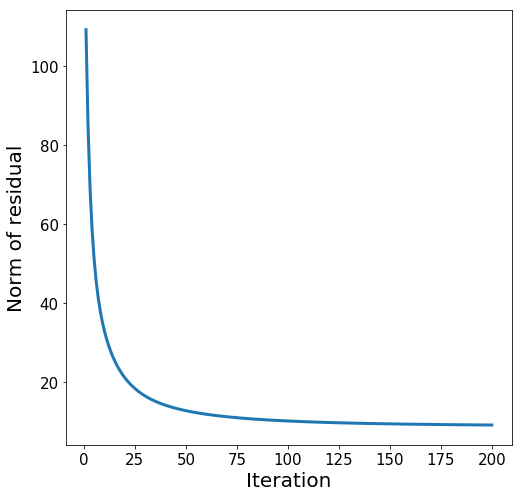

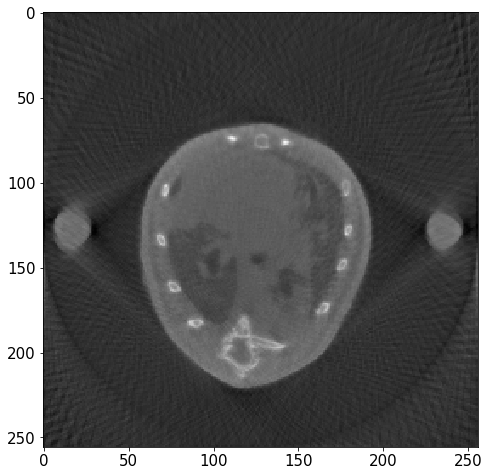

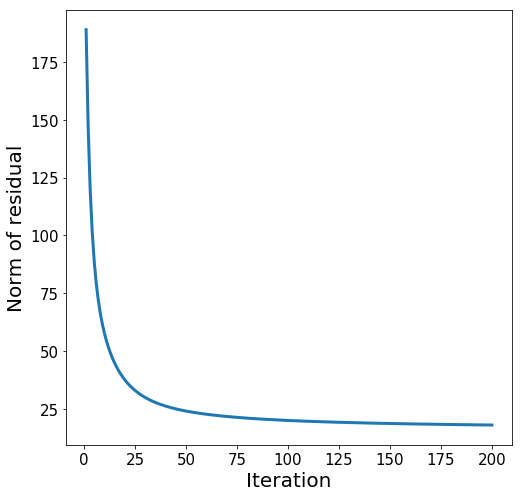

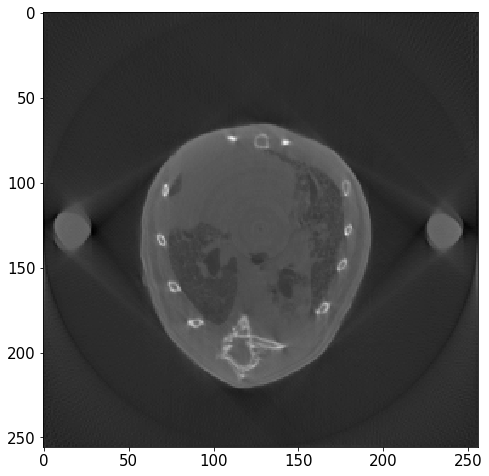

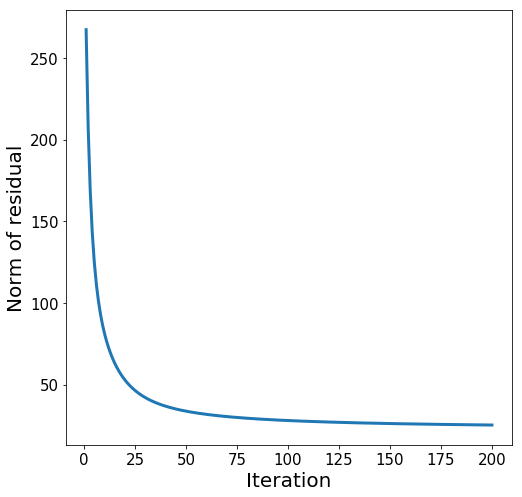

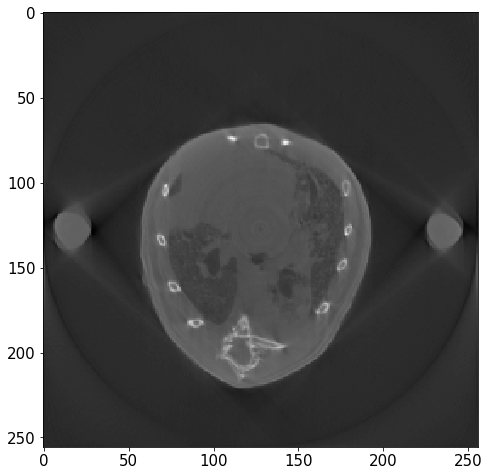

In [5]:
n_pixels = 256

for sinogram, operator, out_prefix in datasets:
    print(f"Running SART for {out_prefix}")
    # Read in the sinogram
    sinogram = scio.loadmat(sinogram)["sino"]
    sinogram = sinogram.flatten(order="F")

    # Read in the imaging operator and convert to CSR format
    operator = scio.loadmat(operator)["A"]
    operator = operator.tocsr()

    model_init = np.zeros(n_pixels**2)
    model, residual_norms, fig = sart(operator, sinogram, model_init, max_iter=200)
    fig.savefig(f"{out_prefix}Residuals.png")
    # Show the reconstructed image
    fig, ax = plt.subplots()
    ax.imshow(model)
    fig.savefig(f"{out_prefix}Image.png")

    # Save the reconstruction to file
    np.savetxt(f"{out_prefix}Reconstruction.txt", model, delimiter="\t", newline="\n")